In [1]:
import torch
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
import pickle
import torch.nn as nn
import numpy as np

In [2]:
def load_net(file_path):   
    pkl_file = open(file_path, 'rb')
    net= pickle.load(pkl_file)
    pkl_file.close()
    return net

def ini():
    kernel=torch.zeros([8,3,3,3])
    array_0=np.array([[1,2,1],[0,0,0],[-1,-2,-1]],dtype='float32')
    array_1=np.array([[2,1,0],[1,0,-1],[0,-1,-2]],dtype='float32')
    array_2=np.array([[1,0,-1],[2,0,-2],[1,0,-1]],dtype='float32')
    array_3=np.array([[0,-1,-2],[1,0,-1],[2,1,0]],dtype='float32')
    array_4=np.array([[-1,-2,-1],[0,0,0],[1,2,1]],dtype='float32')
    array_5=np.array([[-2,-1,0],[-1,0,1],[0,1,2]],dtype='float32')
    array_6=np.array([[-1,0,1],[-2,0,2],[-1,0,1]],dtype='float32')
    array_7=np.array([[0,1,2],[-1,0,1],[-2,-1,0]],dtype='float32')
    for i in range(3):
        kernel[0,i,:]=torch.from_numpy(array_0)
        kernel[1,i,:]=torch.from_numpy(array_1)
        kernel[2,i,:]=torch.from_numpy(array_2)
        kernel[3,i,:]=torch.from_numpy(array_3)
        kernel[4,i,:]=torch.from_numpy(array_4)
        kernel[5,i,:]=torch.from_numpy(array_5)
        kernel[6,i,:]=torch.from_numpy(array_6)
        kernel[7,i,:]=torch.from_numpy(array_7)
    return torch.nn.Parameter(kernel,requires_grad=True) 

class Net(nn.Module):
    def __init__(self,frag_size,psize):
        super(Net, self).__init__()
       
        h_fr=frag_size
        w_fr=frag_size
        
        n=int(h_fr/psize) #    n*m patches dans le patch d'entrée
        m=int(w_fr/psize)
        
        self.conv1 = nn.Conv2d(3,4,kernel_size=3,stride=1,padding=1)
        #    Si vous souhaitez initialiser Conv1 avec les poids de DeepMatch, exécutez la ligne suivante
        #    self.conv1.weight=ini()
        self.Relu = nn.ReLU(inplace=True)
        self.maxpooling=nn.MaxPool2d(3,stride=2, padding=1)
        
        self.shift1=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
        self.shift1.weight=kernel_shift_ini(n,m)
        self.add1 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
        self.add1.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:#   Si n=m=1，Notre réseau n'a plus besoin de plus de couches pour agréger les cartes de corrélation
            self.shift2=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift2.weight=kernel_shift_ini(n,m)
            self.add2 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add2.weight=kernel_add_ini(n,m)
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            self.shift3=nn.Conv2d(n*m,n*m,kernel_size=3,stride=1,padding=1)
            self.shift3.weight=kernel_shift_ini(n,m)
            self.add3 = nn.Conv2d(n*m,int(n/2)*int(m/2),kernel_size=1,stride=1,padding=0)
            self.add3.weight=kernel_add_ini(n,m)
              
    def get_descripteur(self,img,using_cuda):
        #   Utilisez Conv1 pour calculer le descripteur,
        descripteur_img=self.Relu(self.conv1(img))
        b,c,h,w=descripteur_img.shape
        couche_constante=0.5*torch.ones([1,1,h,w])
        if using_cuda:
            couche_constante=couche_constante.cuda()
        #    Ajouter une couche constante pour éviter la division par 0 lors de la normalisation
        descripteur_img=torch.cat((descripteur_img,couche_constante),1)
        #    la normalisation
        descripteur_img_norm=descripteur_img/torch.norm(descripteur_img,dim=1)
        return descripteur_img_norm
    
    def forward(self,img,frag,using_cuda):
        psize=4
        #   Utilisez Conv1 pour calculer le descripteur,
        descripteur_input1=self.get_descripteur(img,using_cuda)
        descripteur_input2=self.get_descripteur(frag,using_cuda)
        
        b,c,h,w=frag.shape
        n=int(h/psize)
        m=int(w/psize)
        
        #######################################
        #    Calculer la carte de corrélation par convolution pour les n*m patchs plus petit.
        for i in range(n):
            for j in range(m):
                if i==0 and j==0:
                    map_corre=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                else:
                    a=F.conv2d(descripteur_input1,get_patch(descripteur_input2,psize,i,j),padding=2)
                    map_corre=torch.cat((map_corre,a),1)
        ########################################
        #    Étape de polymérisation
        map_corre=self.maxpooling(map_corre)
        map_corre=self.shift1(map_corre)
        map_corre=self.add1(map_corre)
        
        #########################################
        #    Répétez l'étape d'agrégation jusqu'à obtenir le graphique de corrélation du patch d'entrée
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift2(map_corre)
            map_corre=self.add2(map_corre)
        
        
        n=int(n/2)
        m=int(m/2)
        if n>=2 and m>=2:
            map_corre=self.maxpooling(map_corre)
            map_corre=self.shift3(map_corre)
            map_corre=self.add3(map_corre)
        
        
        b,c,h,w=map_corre.shape
        #   Normalisation de la division par maximum
        map_corre=map_corre/(map_corre.max())
        #   Normalisation SoftMax
        #map_corre=(F.softmax(map_corre.reshape(1,1,h*w,1),dim=2)).reshape(b,c,h,w)
        return map_corre

def normalize(a):
    return((a - np.min(a))/np.ptp(a))

def carte(w,save_filename,title):
    
    fig,axs = plt.subplots(3,8,figsize=(15,8))
    
    max_ptp = 0
    ref_im = None
    
    for i in range(3):
        for j in range(8):
            im = axs[i,j].imshow(normalize(w[j,i,:,:]))
            
            if i == 0:
                axs[i,j].set_title('Couche {}'.format(j))
            if j == 0:
                axs[i,j].set_ylabel('Channel {}'.format(i+1))
            
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    
    
    fig.suptitle("{}".format(title),fontsize=16)
    
    if save_filename != None:
        plt.savefig(save_filename)
    #plt.close()

def carte4(w,save_filename,title):
    
    fig,axs = plt.subplots(3,4,figsize=(15,8))
    
    max_ptp = 0
    ref_im = None
    
    for i in range(3):
        for j in range(4):
            im = axs[i,j].imshow(normalize(w[j,i,:,:]))
            
            if i == 0:
                axs[i,j].set_title('Couche {}'.format(j))
            if j == 0:
                axs[i,j].set_ylabel('Channel {}'.format(i+1))
            
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    
    
    fig.suptitle("{}".format(title),fontsize=16)
    
    if save_filename != None:
        plt.savefig(save_filename)
    #plt.close()
    
def carte_32(w,save_filename,title):
    
    fig,axs = plt.subplots(3,4,figsize=(15,8))
    
    max_ptp = 0
    ref_im = None
    
    for i in range(3):
        for j in range(4):
            #im = axs[i,j].imshow(normalize(w[j,i,:,:]))
            im = axs[i,j].imshow(w[j,i,:,:],cmap='coolwarm')
            
            for a in range(3):
                for b in range(3):
                    text = axs[i,j].text(b, a, round(w[j, i, a, b],2),
                                   ha="center", va="center", color="w")
            
            if i == 0:
                axs[i,j].set_title('Couche {}'.format(j))
            if j == 0:
                axs[i,j].set_ylabel('Channel {}'.format(i+1))
            
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    mini,maxi = np.min(w),np.max(w)
    
    cmap = matplotlib.cm.coolwarm
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax,orientation='vertical')
    
    
    
    fig.suptitle("{}".format(title),fontsize=16)
    
    if save_filename != None:
        plt.savefig(save_filename)
    #plt.close()

(8, 3, 3, 3)


<IPython.core.display.Javascript object>


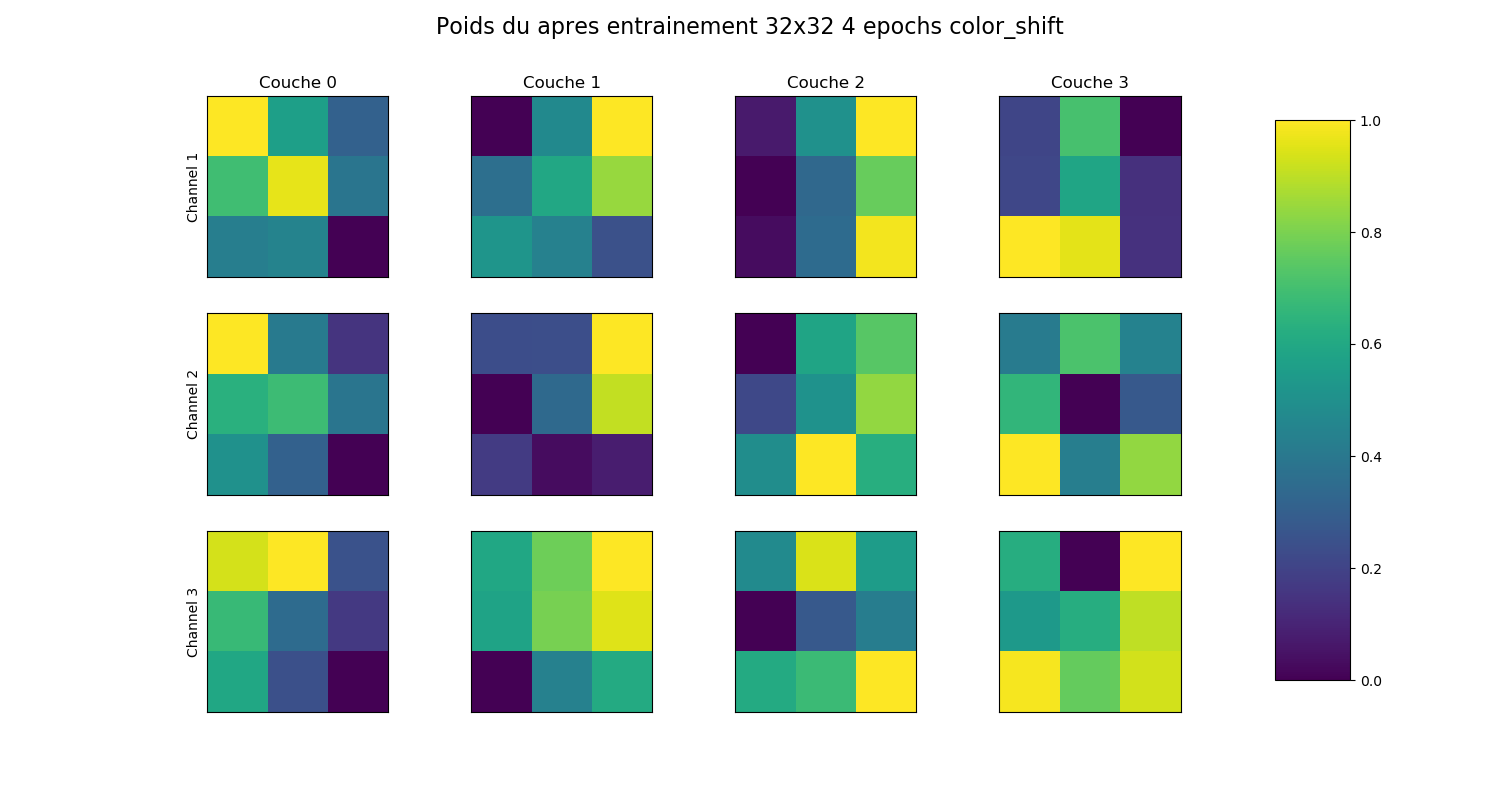

In [4]:
model_filename = './trained_net/net_trainned_SLLShift_E3_03-10_21-02_0007'

net = load_net(model_filename)

w = net.conv1.weight.data.cpu().numpy()

print(w.shape)

carte4(w,'poids_32_E4.svg',"Poids du apres entrainement 32x32 4 epochs color_shift")


In [ ]:
w_values_filename = './trained_net/save_weights_NOMB02-18_20-39_0005'

with open(w_values_filename,'rb') as f:
    w_values = pickle.load(f)

#print(w_values[0][0])
#print(w_values[-1][0])
    
carte4(w_values[0],None,'Premiere')
carte4(w_values[-1],None,'Derniere')


In [ ]:
w_values_filename = './trained_net/save_weights_02-03_01-33_0002'

with open(w_values_filename,'rb') as f:
    w_values = pickle.load(f)

save_filename = './results/images_weights/image{:05}.png'

N = len(w_values)
for i,w in enumerate(w_values):
    print(w.shape)
    print("Generating carte {}/{}".format(i,N))
    carte(w,save_filename.format(i),i*10)
    
print("Done.")
